## STEP-1: Import all required packages

In [632]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## STEP-2: Load the dataset

In [592]:
# Load the dataset. 
# df = pd.read_csv("Loan/loan.csv")

# Got an warning DtypeWarning: Columns (47) have mixed types. so reload the dataseet with low_memory=False
df = pd.read_csv("Loan/loan.csv", low_memory=False)

## Data understanding

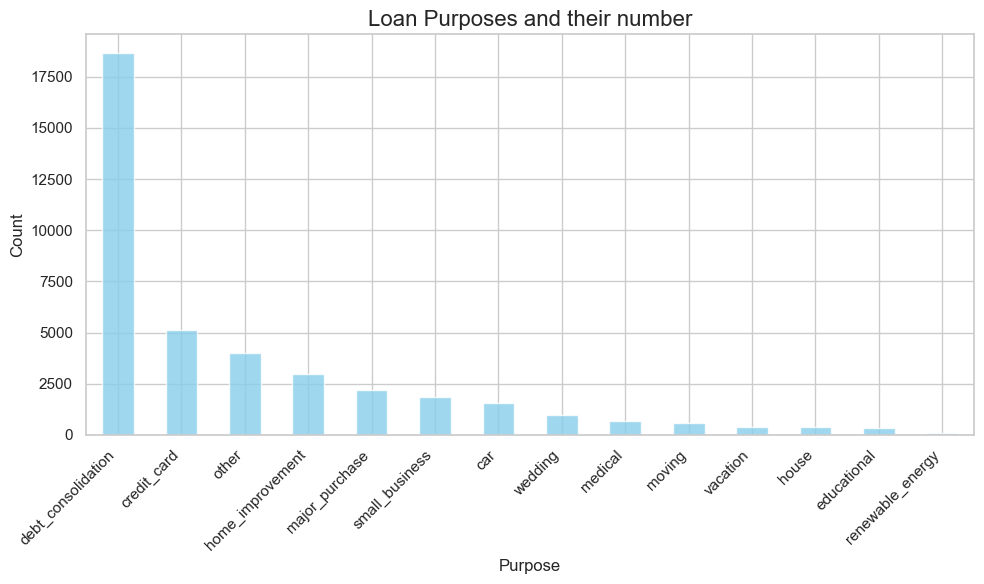

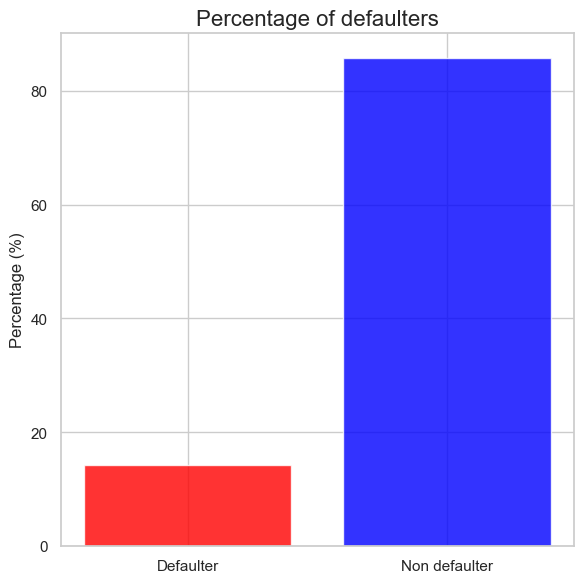

In [683]:
# Let's understand what is the most significant purpose for which loans are given

# Get the counts for each category in 'purpose'
purpose_counts = df['purpose'].value_counts()

# Plot the bar chart
plt.figure(figsize=(10, 6))
purpose_counts.plot(kind='bar', color='skyblue', alpha=0.8)

# Add titles and labels
plt.title('Loan Purposes and their number', fontsize=16)
plt.xlabel('Purpose', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


# Default rate of customers
# Calculate percentages for loan statuses
loan_status_counts = df['loan_status'].value_counts(normalize=True) * 100

# Extract the "Charged Off" percentage
charged_off_percentage = loan_status_counts['Charged Off']

# Prepare data for the bar plot
data = {'Defaulter': charged_off_percentage, 'Non defaulter': 100 - charged_off_percentage}

# Plot the bar chart
plt.figure(figsize=(6, 6))
plt.bar(data.keys(), data.values(), color=['red', 'blue'], alpha=0.8)

# Add titles and labels
plt.title('Percentage of defaulters', fontsize=16)
plt.ylabel('Percentage (%)', fontsize=12)
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

## STEP-3: Data cleaning and preprocessing

In [594]:
# Drop columns where all values are NULL
df = df.dropna(axis=1, how='all')

# As loan_status column signifies whether a customre was defaulted or not we can consider this column as out target variable.
# Check loan status and derive a new column which will store boolean value 0 or 1
# This column will be used to compare against other variables. Those with loan status as 'charged off' are set 1 otherwise 0
df['is_default'] = df['loan_status'].apply(lambda x: 1 if x == 'Charged Off' else 0)

# Remove % from int_rate columns. Convert int_rate values from string to numeric (float)
# df['int_rate'] = df.apply(lambda x: df['int_rate'].str.replace('%', '').astype(float)
df['int_rate'] = df['int_rate'].apply(lambda x: x.replace('%', '') if '%' in str(x) else x).astype(float)

# 1. Drop columns with more than 50% missing values
columns_eligible_to_be_dropped = []
missing_percent = df.isnull().mean() * 100
columns_with_missing = missing_percent[missing_percent > 50].index
columns_eligible_to_be_dropped.extend(columns_with_missing)

# Find numeric columns with no variation
numeric_cols = df.select_dtypes(include=['number'])
same_value_columns = numeric_cols.columns[numeric_cols.describe().loc['std'] == 0]
columns_eligible_to_be_dropped.extend(same_value_columns)
print("Columns where all values are the same:", same_value_columns.tolist())

# Select only categorical columns where all values are same
categorical_cols = df.select_dtypes(include=['object', 'category'])
same_value_categorical_columns = categorical_cols.columns[categorical_cols.nunique() == 1]
columns_eligible_to_be_dropped.extend(same_value_categorical_columns)
print("Categorical columns where all values are the same:", same_value_categorical_columns.tolist())



Columns where all values are the same: ['collections_12_mths_ex_med', 'policy_code', 'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt', 'tax_liens']
Categorical columns where all values are the same: ['pymnt_plan', 'initial_list_status', 'application_type']


## STEP-4: Univariate analysis

In [596]:

# Now let's analyze each columns which can be dropped

# Let's analyze id column
df['id'].value_counts()
df['id'].nunique() # All values are non unique. So, does not have significance. can be dropped.
columns_eligible_to_be_dropped.append('id')

df['member_id'].value_counts()
df['member_id'].nunique()
columns_eligible_to_be_dropped.append('member_id')

# Here a high number of unique job title suggests high cardinaltiy so we can consider this column to drop
df['emp_title'].value_counts()
columns_eligible_to_be_dropped.append('emp_title')

# We will extract the quarter of the year from the date and see if any insights
df['issue_d'].value_counts()

df['url'].value_counts()
columns_eligible_to_be_dropped.append('url')

# It can be dropeed as we have another column where Purpose of the loan is captured.
df['desc'].value_counts()
columns_eligible_to_be_dropped.append('desc')

# Can be segregated based on zip_code to find if any insight
df['zip_code'].value_counts()

df = df.drop(columns=columns_eligible_to_be_dropped)
print(df.columns)

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'issue_d', 'loan_status',
       'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'inq_last_6mths', 'open_acc', 'pub_rec',
       'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv',
       'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d',
       'pub_rec_bankruptcies', 'is_default'],
      dtype='object')


## STEP-5: Bivariate analysis

              count          mean          std    min     25%      50%  \
is_default                                                               
0           34090.0  11073.372690  7337.530962  500.0  5450.0   9800.0   
1            5627.0  12104.385108  8085.732038  900.0  5600.0  10000.0   

                75%      max  
is_default                    
0           15000.0  35000.0  
1           16500.0  35000.0  


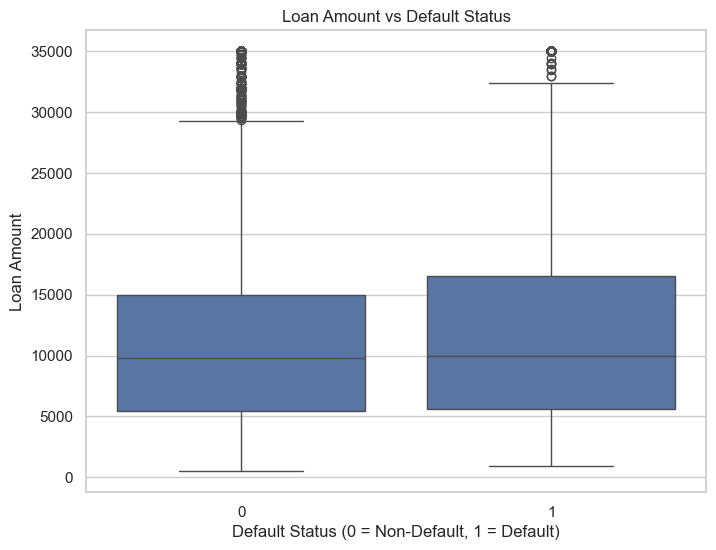

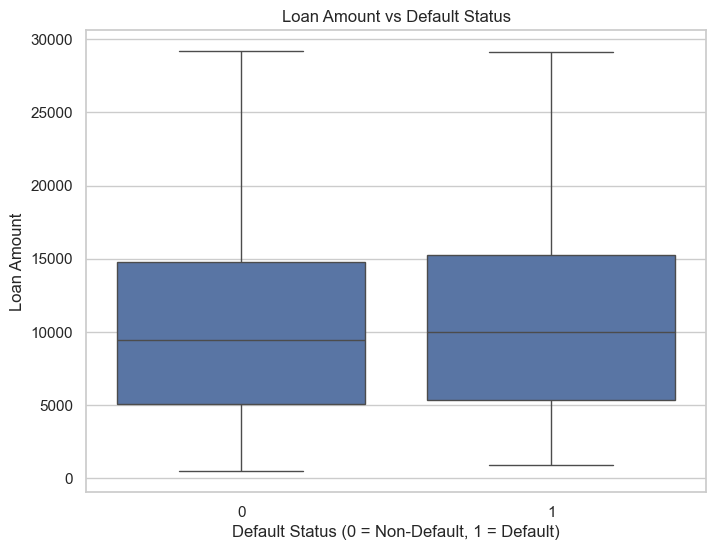

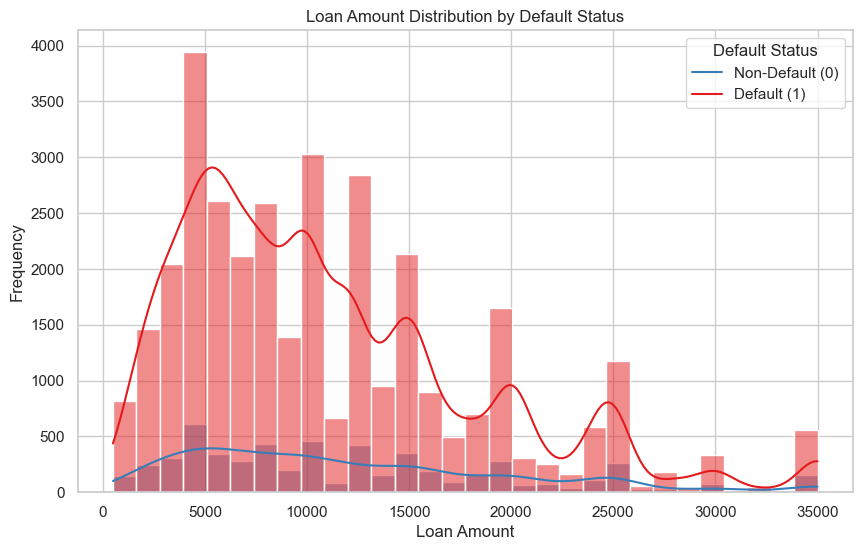

In [598]:
# Exmine distribution of loan_amt for defaulters and non defaulter.

# Descriptive statistics for loan amount by default status
stats = df.groupby('is_default')['loan_amnt'].describe()
print(stats)

# From the result we can see more no. of non defaulters are present in the dataset. On average defaulters have taken loadn amount slightly higher
# than non defaulters. Variation in loadn amount is also higher for non defaulters. Defaulters have higher 75th percentile value that means defaulters
# have taken higher loan amounts.

# We can assume defaulters have slightly higher loan amount. But let's visulaize the difference to get better understanding.

plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='is_default', y='loan_amnt')
plt.title("Loan Amount vs Default Status")
plt.xlabel("Default Status (0 = Non-Default, 1 = Default)")
plt.ylabel("Loan Amount")
plt.show()

# Remove outliers and replot the boxplot.
df_outliers_removed = calculateIQR('loan_amnt')

plt.figure(figsize=(8, 6))
sns.boxplot(data=df_outliers_removed, x='is_default', y='loan_amnt')
plt.title("Loan Amount vs Default Status")
plt.xlabel("Default Status (0 = Non-Default, 1 = Default)")
plt.ylabel("Loan Amount")
plt.show()

# Plotting histogram of loan amounts with KDE
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='loan_amnt', hue='is_default', kde=True, bins=30, palette='Set1')
plt.title("Loan Amount Distribution by Default Status")
plt.xlabel("Loan Amount")
plt.ylabel("Frequency")
plt.legend(title="Default Status", labels=["Non-Default (0)", "Default (1)"])
plt.show()

# Conclusion: Borrower within loan amount 5000-15000 range are more defaulters.
# Defaulters have taken higher loan amount(Some even higher than 35000) than non defaulter as seen from the hist plot

In [624]:
stats = df.groupby('is_default')['term'].value_counts()
print(stats)
# Does not give any clear insights from the stats.

stats1 = df.groupby('is_default')['grade'].value_counts()
print(stats1)

is_default  term     
0           36 months    25869
            60 months     8221
1           36 months     3227
            60 months     2400
Name: count, dtype: int64
is_default  grade
0           B        10595
            A         9483
            C         6751
            D         4189
            E         2127
            F          730
            G          215
1           B         1425
            C         1347
            D         1118
            E          715
            A          602
            F          319
            G          101
Name: count, dtype: int64


              count       mean       std   min    25%    50%    75%    max
is_default                                                                
0           34090.0  11.724186  3.652109  5.42   8.88  11.49  14.17  24.59
1            5627.0  13.820432  3.654413  5.42  11.31  13.61  16.40  24.40


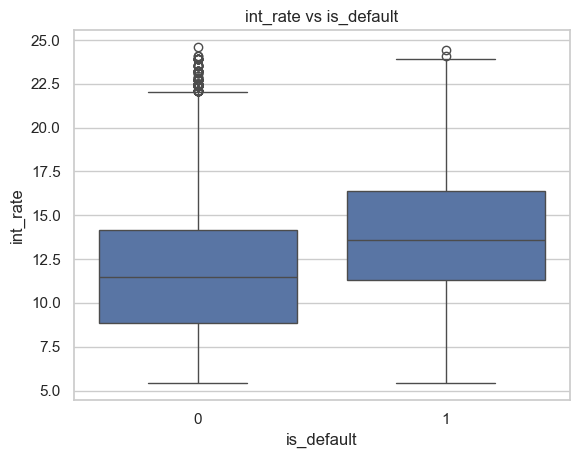

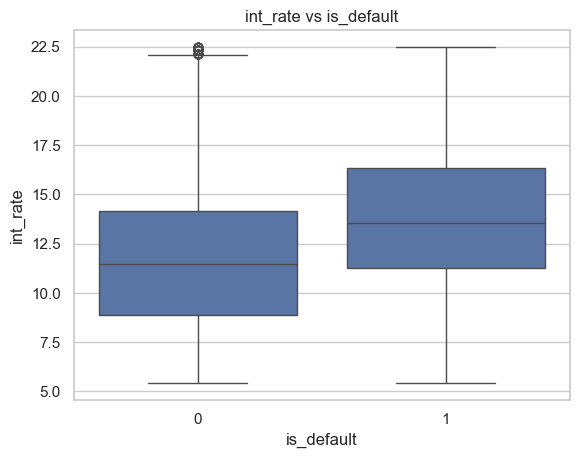

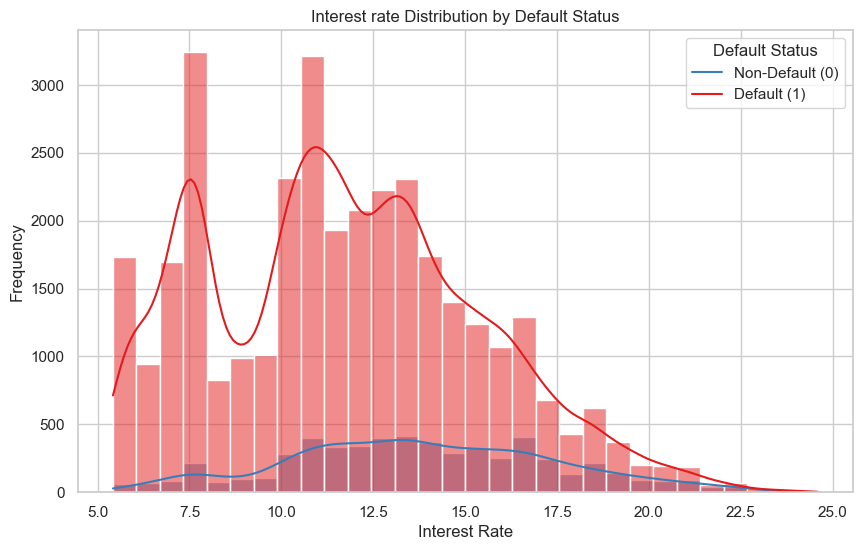

In [614]:
# Descriptive statistics for loan amount by default status
stats = df.groupby('is_default')['int_rate'].describe()
print(stats)

# Let's understand how interest rates vary for defaulters and non defaulters using box plot
sns.boxplot(data=df, x='is_default', y='int_rate')
plt.title('int_rate vs is_default')
plt.show()

# From the above box plot it's evident there are some outliers for the non defaulters. Let's remove those using IQR method.
df_filtered = calculateIQR('int_rate')

sns.boxplot(data=df_filtered, x='is_default', y='int_rate')
plt.title('int_rate vs is_default')
plt.show()

# From the box plot it is evident that the defaulters have a higher median interest rate. Let's plot a histogram to see distribution of interest rate
# for defaulters and non defaulters.

# Plotting histogram of loan amounts with KDE
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='int_rate', hue='is_default', kde=True, bins=30, palette='Set1')
plt.title("Interest rate Distribution by Default Status")
plt.xlabel("Interest Rate")
plt.ylabel("Frequency")
plt.legend(title="Default Status", labels=["Non-Default (0)", "Default (1)"])
plt.show()

# Conclusion: It is clearly evident fromt the plot that defaulters have higher interest rate than non defaulters raning from 5-15
# Defaulters have wide range of interest rate from 5-22

                total_loans  total_defaults  default_rate
home_ownership                                           
MORTGAGE              17659            2327      0.131774
NONE                      3               0      0.000000
OTHER                    98              18      0.183673
OWN                    3058             443      0.144866
RENT                  18899            2839      0.150220


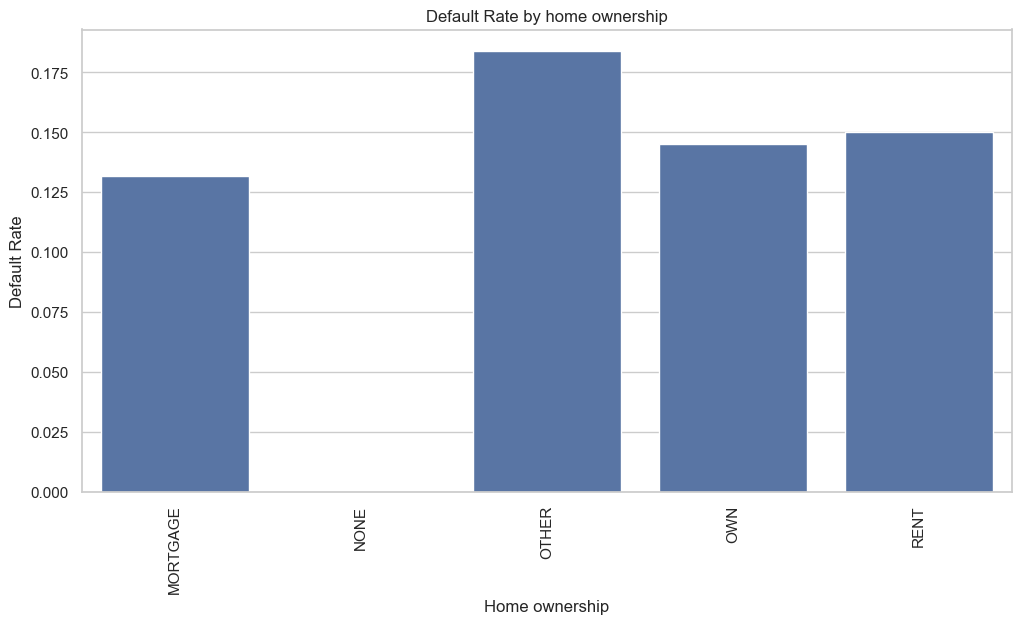

In [649]:
# Let's find out % of defaulters among different categories of home ownerhsip
# Define the custom function
home_ownership_analysis = df.groupby('home_ownership').agg(
    total_loans=('loan_status', 'count'),
    total_defaults=('loan_status', lambda x: (x == 'Charged Off').sum())
)
home_ownership_analysis['default_rate'] = home_ownership_analysis['total_defaults'] / home_ownership_analysis['total_loans']

print(home_ownership_analysis)

plt.figure(figsize=(12, 6))
sns.barplot(x=home_ownership_analysis.index, y=home_ownership_analysis['default_rate'])
plt.title('Default Rate by home ownership')
plt.xlabel('Home ownership')
plt.ylabel('Default Rate')
plt.xticks(rotation=90)
plt.show()

# Conclusion: Customers who rent tends to be slightly higher defaulters(15%).

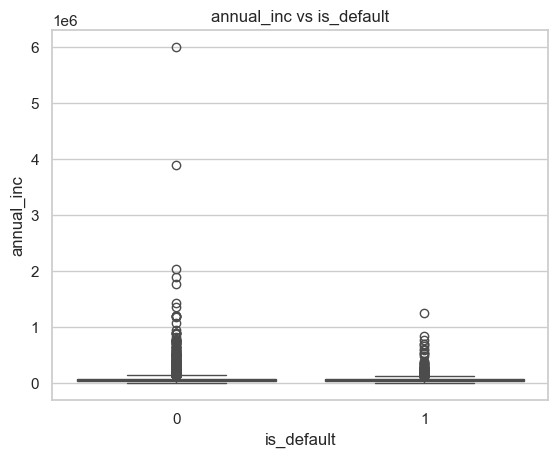

Original dataset size: 39717
Dataset size after removing outliers: 37874


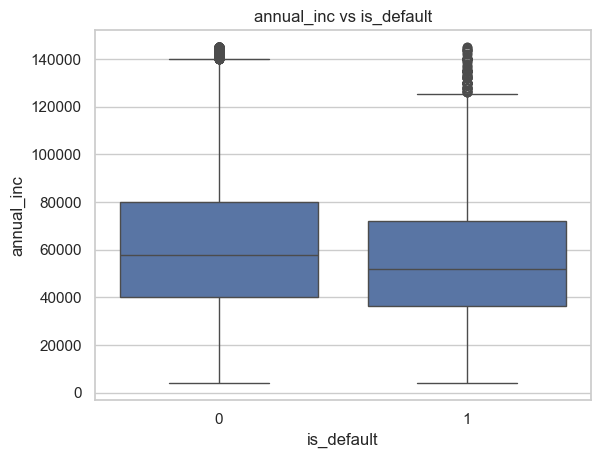

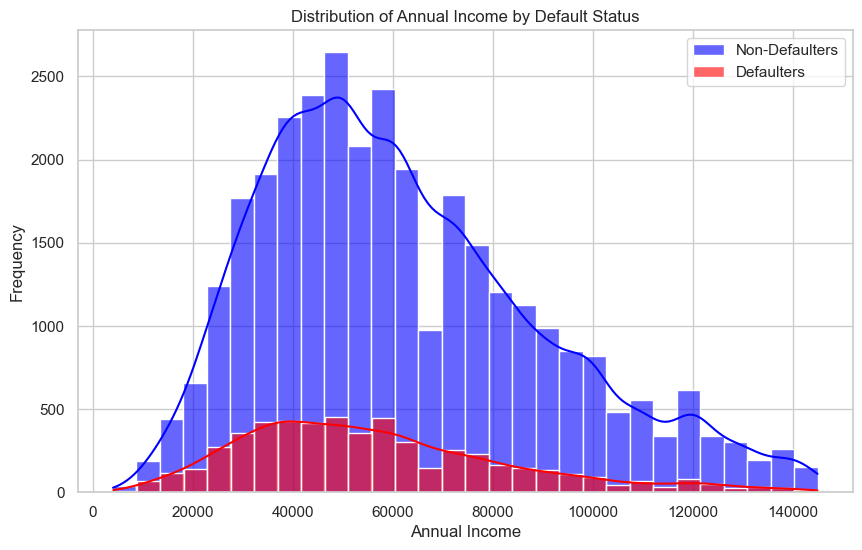

In [637]:
# Now let's understand how annual_inc relate wrt defaulter status

sns.boxplot(data=df, x='is_default', y='annual_inc')
plt.title('annual_inc vs is_default')
plt.show()

# # From the box plot it's evident there are some outliers for the non defaulters. Let's remove those using IQR method.
df_filtered1 = calculateIQR('annual_inc')

print(f"Original dataset size: {df.shape[0]}")
print(f"Dataset size after removing outliers: {df_filtered1.shape[0]}")

sns.boxplot(data=df_filtered1, x='is_default', y='annual_inc')
plt.title('annual_inc vs is_default')
plt.show()

# From the box plot it is clearly evident that there are still lot of outliers present so let's try with histogram
# Histogram for annual_income for defaulters vs non-defaulters
plt.figure(figsize=(10, 6))

# Plot for non-defaulters (0)
sns.histplot(df_filtered1[df_filtered1['is_default'] == 0]['annual_inc'], bins=30, kde=True, color='blue', label='Non-Defaulters', alpha=0.6)

# Plot for defaulters (1)
sns.histplot(df_filtered1[df_filtered1['is_default'] == 1]['annual_inc'], bins=30, kde=True, color='red', label='Defaulters', alpha=0.6)

plt.title('Distribution of Annual Income by Default Status')
plt.xlabel('Annual Income')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# From the histogram we can visualize that the highest no. of defaulters as well as non defaulters are in the income range of 30000 to 500000 peaking around 40000
#  But density of defaulters in higher income range is thinner than non defaulters. It suggests customers with lower income are defaulted more.

In [601]:
# Verification status against defaulter status
df['verification_status'].value_counts()
pd.crosstab(df['verification_status'], df['is_default'], normalize='columns')

#From the result we can conclude that higher percentage of verified customers are defaulters where as 
# higher percentage of not verfied customers are non defaulters

is_default,0,1
verification_status,,
Not Verified,0.433529,0.380665
Source Verified,0.250895,0.254843
Verified,0.315576,0.364493


           total_loans  total_defaults  default_rate
sub_grade                                           
A1                1139              30      0.026339
A2                1508              74      0.049072
A3                1810             103      0.056906
A4                2886             178      0.061677
A5                2742             217      0.079139
B1                1830             171      0.093443
B2                2057             228      0.110841
B3                2917             341      0.116901
B4                2512             329      0.130971
B5                2704             356      0.131657
C1                2136             336      0.157303
C2                2011             321      0.159622
C3                1529             270      0.176586
C4                1236             212      0.171521
C5                1186             208      0.175379
D1                 931             167      0.179377
D2                1348             271      0.

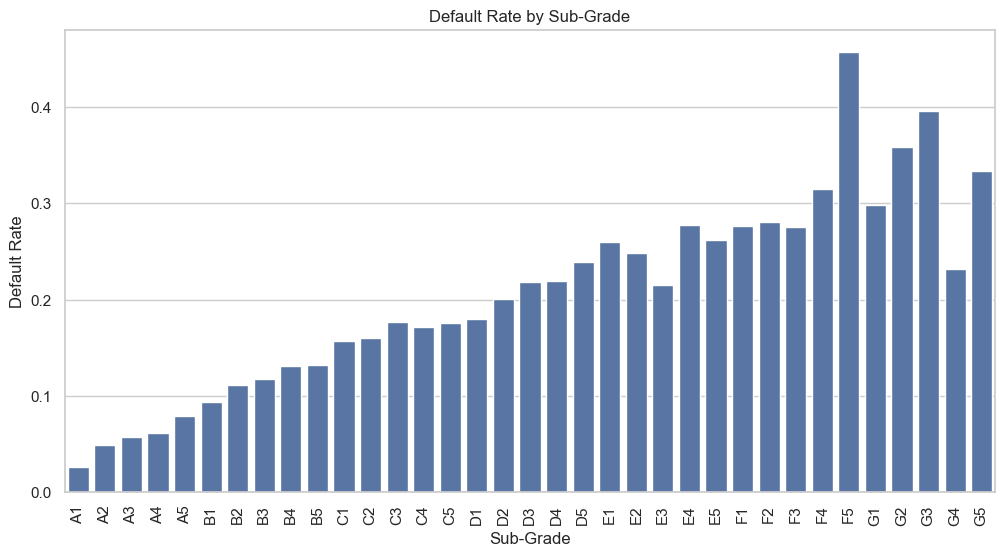

In [634]:
# Analysisng sub_grade
subgrade_analysis = df.groupby('sub_grade').agg(
    total_loans=('loan_status', 'count'),
    total_defaults=('loan_status', lambda x: (x == 'Charged Off').sum())
)
subgrade_analysis['default_rate'] = subgrade_analysis['total_defaults'] / subgrade_analysis['total_loans']

print(subgrade_analysis)


plt.figure(figsize=(12, 6))
sns.barplot(x=subgrade_analysis.index, y=subgrade_analysis['default_rate'])
plt.title('Default Rate by Sub-Grade')
plt.xlabel('Sub-Grade')
plt.ylabel('Default Rate')
plt.xticks(rotation=90)
plt.show()

# Conclusion: We can conclude that customer with sub_grade A1 are least default where as customers with sub_grade F5 are highest defaulter.

count    39717.000000
mean        12.021177
std          3.724825
min          5.420000
25%          9.250000
50%         11.860000
75%         14.590000
max         24.590000
Name: int_rate, dtype: float64


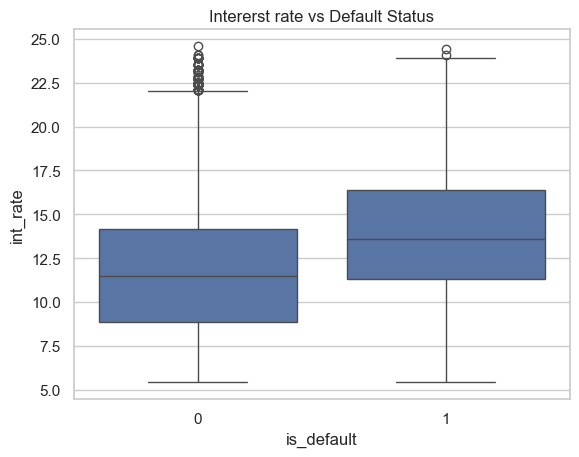

In [603]:
# As from above visualization we couldn't conclude loan amount is driving the defaulters
# leet's compare another variable mayb interest rate.

# sns.boxplot(data=df, x='is_default', y='int_rate')
# plt.title('Intererst rate vs Default Status')
# plt.show()

# Replace the % with '' and convert to float
# df['int_rate'] = df['int_rate'].str.replace('%', '').astype(float)
print(df['int_rate'].describe())

sns.boxplot(data=df, x='is_default', y='int_rate')
plt.title('Intererst rate vs Default Status')
plt.show()

#As analysed from the box plot defaulter seems to have higher interest rate than non defaulters.
# Now try to analyze interest rate with other values like loan amount we can do multivariate analysis.



In [653]:
# Check if higher delinquencies correlate with default rates. For instance:
df.groupby('loan_status')['delinq_2yrs'].mean()



loan_status
Charged Off    0.170606
Current        0.141228
Fully Paid     0.142580
Name: delinq_2yrs, dtype: float64

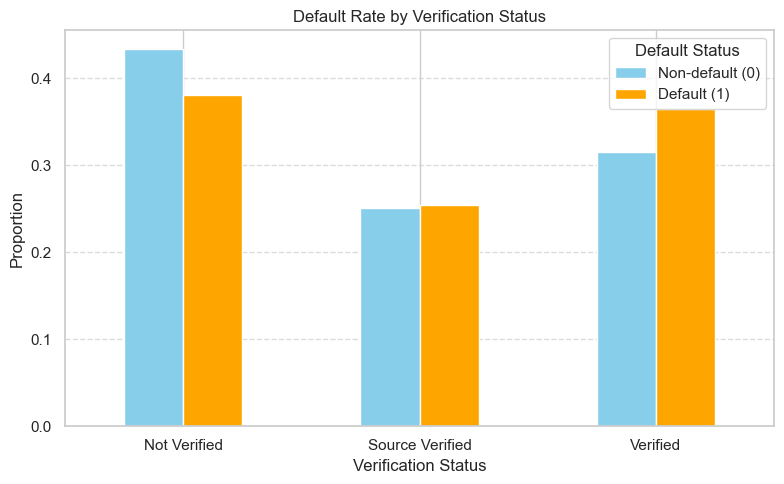

In [657]:
df['verification_status'].value_counts()
verification_crosstab = pd.crosstab(df['verification_status'], df['is_default'], normalize='columns')

verification_crosstab.plot(kind='bar', figsize=(8, 5), color=['skyblue', 'orange'])
plt.title('Default Rate by Verification Status')
plt.xlabel('Verification Status')
plt.ylabel('Proportion')
plt.legend(['Non-default (0)', 'Default (1)'], title='Default Status')
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Conclusion: Customers having verification status as verified are likely to be defaulted more

In [661]:
df['dti'].describe()

count    39717.000000
mean        13.315130
std          6.678594
min          0.000000
25%          8.170000
50%         13.400000
75%         18.600000
max         29.990000
Name: dti, dtype: float64

In [ ]:
# Create a custom function to calculate IQR and return the filtered data
def calculateIQR (fieldName):
    # Calculate IQR
    Q1 = df[fieldName].quantile(0.25)
    Q3 = df[fieldName].quantile(0.75)
    IQR = Q3 - Q1
    
    # Define boundary
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter the outliers
    filtered_df = df[(df[fieldName] >= lower_bound) & (df[fieldName] <= upper_bound)]
    return filtered_df

In [ ]:
# Create a custom function to calculate default rate